In [1]:
import json
import typing as t

# data prep
import pandas as pd
import numpy as np

# for creating image vector embeddings
from PIL import Image
from img2vec_pytorch import Img2Vec

# for creating semantic (text-based) vector embeddings
from sentence_transformers import SentenceTransformer

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
DATA_PATH = "../../../datasets/product-images/fashion-dataset/"

# load in data and clean data types and drop null rows
metadata = pd.read_csv(DATA_PATH + "/styles.csv", on_bad_lines='skip')
metadata.dropna(inplace=True)
metadata["year"] = metadata["year"].astype(int)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44077 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44077 non-null  int64 
 1   gender              44077 non-null  object
 2   masterCategory      44077 non-null  object
 3   subCategory         44077 non-null  object
 4   articleType         44077 non-null  object
 5   baseColour          44077 non-null  object
 6   season              44077 non-null  object
 7   year                44077 non-null  int64 
 8   usage               44077 non-null  object
 9   productDisplayName  44077 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.7+ MB


In [14]:
# check out some of the JSON data.
data = json.loads(open(DATA_PATH + "/styles/6041.json", "r").read())
data

{'notification': {},
 'meta': {'code': 200, 'requestId': '832d54ee-d88b-4f34-a962-26321d73691c'},
 'data': {'id': 6041,
  'price': 1499,
  'discountedPrice': 1499,
  'styleType': 'P',
  'productTypeId': 289,
  'articleNumber': '11P3084J0926I203',
  'visualTag': '',
  'productDisplayName': "UCB Men's Polo Neck With Lion Logo Navy Blue T-shirt",
  'variantName': 'H/S Polo Neck t-Shirt with Lion Logo',
  'myntraRating': 0,
  'catalogAddDate': 1446705981,
  'brandName': 'United Colors of Benetton',
  'ageGroup': 'Adults-Men',
  'gender': 'Men',
  'baseColour': 'Navy Blue',
  'colour1': '',
  'colour2': '',
  'fashionType': 'Fashion',
  'season': 'Summer',
  'year': '2011',
  'usage': 'Casual',
  'vat': 5.5,
  'displayCategories': 'Casual Wear,Sale',
  'weight': '0',
  'navigationId': 0,
  'landingPageUrl': 'Tshirts/United-Colors-of-Benetton/UCB-Mens-Polo-Neck-With-Lion-Logo-Navy-Blue-T-shirt/6041/buy',
  'articleAttributes': {'Body or Garment Size': 'Garment Measurements in'},
  'crossLink

In [5]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


In [6]:
product_data = metadata.sample(1000)
product_data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
861,19549,Men,Apparel,Topwear,Sweatshirts,Grey,Fall,2011,Casual,United Colors of Benetton Men Solid Grey Sweat...
32650,23991,Men,Apparel,Topwear,Shirts,White,Fall,2011,Casual,Peter England Men White Check Shirt
31979,32228,Women,Apparel,Topwear,Kurtas,Mustard,Summer,2012,Ethnic,Fabindia Women Printed Mustard Kurta
31731,46938,Men,Personal Care,Fragrance,Perfume and Body Mist,Brown,Spring,2017,Casual,York Men Classic Perfume
8725,37759,Men,Apparel,Topwear,Shirts,Grey,Summer,2012,Casual,John Players Men Stripes Grey Shirt
...,...,...,...,...,...,...,...,...,...,...
26812,42049,Women,Accessories,Bags,Clutches,Purple,Summer,2010,Casual,Bulchee Women Purple Clutch
29501,12049,Men,Apparel,Topwear,Sweatshirts,Grey,Fall,2011,Casual,Spykar Men Solid Grey Sweatshirts
9850,24126,Women,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,ADIDAS Women Printed Blue T-shirt
31647,12476,Men,Footwear,Sandal,Sandals,Black,Fall,2012,Casual,Clarks Men Leather Black Sandals


In [8]:
product_meta = []
for index, row in product_data.iterrows():
    product = {"id": row["id"]}
    json_file = DATA_PATH + "/styles/" + str(row["id"]) + ".json"
    # open and read json data
    json_data = json.loads(open(json_file, "r").read())["data"]
    # extract relevant data
    product["brand"] = json_data["brandName"]
    product["age_group"] = json_data["ageGroup"]
    try:
        product["description"] = strip_tags(json_data["productDescriptors"]["description"]["value"])
    except KeyError:
        product["description"] = None
    product["image_url"] = json_data["styleImages"]["default"]["imageURL"]

    product_meta.append(product)

product_meta_from_json = pd.DataFrame(product_meta)
product_meta_from_json

,id,brand,age_group,description,image_url
0,19549,United Colors of Benetton,Adults-Men,Composition Grey ribbed round neck sweatshirt ...,http://assets.myntassets.com/v1/images/style/p...
1,23991,Peter England,Adults-Men,CompositionWhite and brown check shirt with gr...,http://assets.myntassets.com/v1/images/style/p...
2,32228,Fabindia,Adults-Women,"Style Notefabindia specialises in natural, cra...",http://assets.myntassets.com/v1/images/style/p...
3,46938,York,Adults-Men,Style Noteyork perfumes are known for its soph...,http://assets.myntassets.com/v1/images/style/p...
4,37759,John Players,Adults-Men,Style note\nThis john players shirt gets a sar...,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...
995,42049,BULCHEE,Adults-Women,Style Note\nclutches are the latest rage these...,http://assets.myntassets.com/v1/images/style/p...
996,12049,SPYKAR,Adults-Men,CompositionGrey hooded sweatshirt made of 60% ...,http://assets.myntassets.com/v1/images/style/p...
997,24126,ADIDAS,Adults-Women,Composition Blue V-neck T-shirt made of 100% c...,http://assets.myntassets.com/v1/images/style/p...
998,12476,Clarks,Adults-Men,"Inspired by the clog, this Wild Edge sandal fr...",http://assets.myntassets.com/v1/images/style/p...


(array([502.,   0., 411.,   0.,  22.,   0.,   7.,   0.,  44.,  14.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

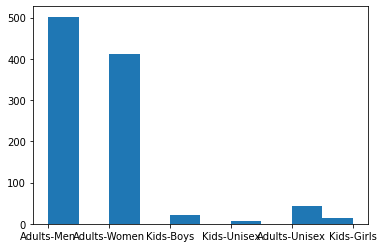

In [9]:
# plot the distribution of the age group
plt.hist(product_meta_from_json["age_group"])

In [103]:
all_product_data = pd.merge(product_meta_from_json, product_data, on="id", how="left")
all_product_data

,id,brand,age_group,description,image_url,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,19549,United Colors of Benetton,Adults-Men,Composition Grey ribbed round neck sweatshirt ...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Sweatshirts,Grey,Fall,2011,Casual,United Colors of Benetton Men Solid Grey Sweat...
1,23991,Peter England,Adults-Men,CompositionWhite and brown check shirt with gr...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Shirts,White,Fall,2011,Casual,Peter England Men White Check Shirt
2,32228,Fabindia,Adults-Women,"Style Notefabindia specialises in natural, cra...",http://assets.myntassets.com/v1/images/style/p...,Women,Apparel,Topwear,Kurtas,Mustard,Summer,2012,Ethnic,Fabindia Women Printed Mustard Kurta
3,46938,York,Adults-Men,Style Noteyork perfumes are known for its soph...,http://assets.myntassets.com/v1/images/style/p...,Men,Personal Care,Fragrance,Perfume and Body Mist,Brown,Spring,2017,Casual,York Men Classic Perfume
4,37759,John Players,Adults-Men,Style note\nThis john players shirt gets a sar...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Shirts,Grey,Summer,2012,Casual,John Players Men Stripes Grey Shirt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,42049,BULCHEE,Adults-Women,Style Note\nclutches are the latest rage these...,http://assets.myntassets.com/v1/images/style/p...,Women,Accessories,Bags,Clutches,Purple,Summer,2010,Casual,Bulchee Women Purple Clutch
996,12049,SPYKAR,Adults-Men,CompositionGrey hooded sweatshirt made of 60% ...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Sweatshirts,Grey,Fall,2011,Casual,Spykar Men Solid Grey Sweatshirts
997,24126,ADIDAS,Adults-Women,Composition Blue V-neck T-shirt made of 100% c...,http://assets.myntassets.com/v1/images/style/p...,Women,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,ADIDAS Women Printed Blue T-shirt
998,12476,Clarks,Adults-Men,"Inspired by the clog, this Wild Edge sandal fr...",http://assets.myntassets.com/v1/images/style/p...,Men,Footwear,Sandal,Sandals,Black,Fall,2012,Casual,Clarks Men Leather Black Sandals


In [115]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spartee/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [116]:
import re
import string
from nltk.corpus import stopwords

eng_stopwords = stopwords.words("english")

# use regex to remove all words after the word "Material"
def clean_description(description):
    if not description:
        return ""
    # remove unicode characters
    description = description.encode('ascii', 'ignore').decode()

    # remove punctuation
    description = re.sub('[%s]' % re.escape(string.punctuation), ' ', description)

    # clean up the spacing
    description = re.sub('\s{2,}', " ", description)

    # remove urls
    description = re.sub("https*\S+", " ", description)

    # remove newlines
    description = description.replace("\n", " ")

    # remove all numbers
    description = re.sub('\w*\d+\w*', '', description)

    # split on capitalized words
    description = " ".join(re.split('(?=[A-Z])', description))

    # remove all words after the word "Material"
    description = re.sub("Material.*", "", description)

    # remove all words after the word "Model"
    description = re.sub("Model.*", "", description)

    # remove the words "wash" "Hand", "Hand Wash", "Hand Washable", "Hand Washable", "cold", "degrees", "detergent", "wring", "bleach", "iron"
    description = re.sub("wash|Hand|Hand Wash|Hand Washable|Hand Washable|cold|degrees|detergent|wring|bleach|iron", "", description)

    # clean up the spacing again
    description = re.sub('\s{2,}', " ", description)

    # make all words lowercase
    description = description.lower()

    # remove stop words (debating whether to include this)
    description = " ".join([word for word in description.split() if word not in eng_stopwords])

    return description

clean_description(all_product_data.description[4])

'style note john players shirt gets sartorial stamp approval refined collar silhouetted tailoring fine luxe fabric make right impression shirt lazy weekends hours dinner best bet semi formal fridays wear fitted denims ankle boots product details yellow grey striped shirt made cotton long sleeves buttoned cuffs spread collar full buttoned placket patch pocket left chest embroidered branding left chest pocket curved hem'

In [117]:
all_product_data["description"] = all_product_data.description.apply(clean_description)
all_product_data.description[5]

'composition teal blue black printed shirt made cotton spread collar short sleeves patch pocket left chest full buttoned placket curved hem fit slim fit wash care machine using mild flat dry shade warm decorations impeccably designed shirt indigo nation remains timeless classic wear chinos denims style understated accessories'

In [118]:
# Resnet-18 to create image embeddings
img2vec = Img2Vec(cuda=False)

# bert variant to create text embeddings
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [119]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [120]:
tf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0,
                     stop_words='english')
tfidf_matrix = tf.fit_transform(all_product_data['description'])

In [121]:
tfidf_matrix.shape

(1000, 28992)

In [122]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [123]:
# write function to get recommendations based on cosine similarity
prods = all_product_data.reset_index()
prod_names = prods['productDisplayName']
indices = pd.Series(prods.index, index=prods['productDisplayName'])

def get_recommendations(product_name):
    try:
        # handle duplicates
        idx = indices[product_name][0]
    except IndexError:
        idx = indices[product_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:15]
    product_indicies = [i[0] for i in sim_scores]
    return prod_names.iloc[product_indicies]

In [126]:
index = 200
name= prods.iloc[index].name
desc = prods.iloc[index].description
print("Name:", name, "\nDescription:", desc)

Name: 200 
Description: composition blue mustard striped shirt polo collar neck made cotton short sleeves patch pocket left chest embroidered brand logo vented hem fitting regular wash care machine similar colours using mild tumble dry low dry shade warm decorations sophistication best shirt classic polo guarantees effortless style whatever occasion cotton fabric offers exemplary comfort pair jeans chinos sneakers


In [127]:
get_recommendations(name)

42                       Proline Men Purple Polo T-shirt
473    U.S. Polo Assn. Men Stripes Navy Blue  Polo Ts...
926                   John Miller Men Check Purple Shirt
289        U.S. Polo Assn. Men Solid Limoges Polo Tshirt
850           Locomotive Men Solid Navy Blue Polo TShirt
489                  U.S. Polo Assn. Men Check Red Shirt
833                       Proline Men White Polo T-shirt
835                        Proline Men Navy Polo T-shirt
303                       Proline Men Brown Polo T-Shirt
367                  Arrow Sport Men Check Purple Shirts
728            Arrow Sport Men Self-Stripes White Shirts
5                   Indigo Nation Men Printed Teal Shirt
593              Reid & Taylor Men Check Navy Blue Shirt
107                   Flying Machine Men HS Green Shirts
Name: productDisplayName, dtype: object

In [ ]:
def generate_text_vectors(products_df):
    text_vectors = {}
    # generate text vector
    for index, row in products_df.iterrows():
        text_vector = model.encode(row["description"])
        text_vectors[row["product_id"]] = text_vector.astype(np.float32)
        if index % 100 == 0:
            print(f"Processed {str(index)} product text fields")
    return text_vectors

generate_text_vectors(all_product_data)


In [90]:
def get_batch(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def generate_image_vectors(products, image_base_path, batch_size=1000):
    output_dict={}

    for batch in get_batch(products, batch_size):
        product_ids = batch['product_id'].values.tolist()
        image_filenames = [image_base_path + "/" + str(_id) + ".jpg" for _id in product_ids]
        images=[]
        converted=[]

        for img_path, _id in zip(image_filenames, product_ids):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))
                images.append(img)
                converted.append(_id)
            except:
                #unable_to_convert -> skip to the next image
                continue

        #Generate vectors for all images in this batch
        vec_list = img2vec.get_vec(images)

        #update the dictionary to be returned
        batch_dict= dict(zip(converted, vec_list))
        output_dict.update(batch_dict)
        print(f"Processed {str(batch_size)} product images")

    return output_dict

def generate_text_vectors(products_df):
    text_vectors = {}
    # generate text vector
    for index, row in products_df.iterrows():
        text_vector = model.encode(row["product_text"])
        text_vectors[row["product_id"]] = text_vector.astype(np.float32)
        if index % 1000 == 0:
            print(f"Processed {str(index)} product text fields")
    return text_vectors

# combine into a single json file
def combine_vector_dicts(txt_vectors, img_vectors, products):
    product_vectors = []
    for _, row in products.iterrows():
        try:
            _id = row["product_id"]
            text_vector = txt_vectors[_id].tolist()
            img_vector = img_vectors[_id].tolist()
            vector_dict = {
                "text_vector": text_vector,
                "img_vector": img_vector,
                "product_id": _id
            }
            product_vectors.append(vector_dict)
        except KeyError:
            continue
    return product_vectors

def write_product_vector_json(vector_dict):
    product_vector_json = json.dumps(vector_dict)
    with open("./product_vectors.json", "w") as f:
        f.write(product_vector_json)

def write_product_metadata_json(metadata_df):
    products = []
    for _, row in metadata_df.iterrows():
        product = {
            "product_id": row["product_id"],
            # create a text based representation to create a semantic embedding with
            "product_metadata": {
                "name": row["productDisplayName"],
                "gender": row["gender"],
                "master_category": row["masterCategory"],
                "sub_category": row["subCategory"],
                "article_type": row["articleType"],
                "base_color": row["baseColour"],
                "season": row["season"],
                "year": row["year"],
                "usage": row["usage"]
            }
        }
        products.append(product)

    products_json = json.dumps(products)
    with open("./product_metadata.json", "w") as f:
        f.write(products_json)


In [91]:
data_path = "../app/vecsim_app/static/images"
num_products = 10000
image_vectors = generate_image_vectors(metadata[:num_products], data_path, batch_size=1000)
text_vectors = generate_text_vectors(metadata[:num_products])
vector_dict = combine_vector_dicts(text_vectors, image_vectors, metadata)
write_product_vector_json(vector_dict)
write_product_metadata_json(metadata[:num_products])



Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 1000 product images
Processed 0 product text fields
Processed 1000 product text fields
Processed 2000 product text fields
Processed 3000 product text fields
Processed 4000 product text fields
Processed 5000 product text fields
Processed 6000 product text fields
Processed 7000 product text fields
Processed 8000 product text fields
Processed 9000 product text fields
Processed 10000 product text fields
